# Comment (Processing) EXTRAS 02

### Comment Type

We still have some extra questions we could answer with the comment data.

---

In Comment Processing 03 we saw which parties applaude which parties and in Comment Extras 01 we saw which are most popular.

Now we want to take a closer look and do the same for individual speakers.


In [69]:
import pandas as pd
import numpy as np
from util.getComments import getComments
from util.countApplause import countApplause
import matplotlib.pyplot as plt
from tueplots import bundles
from util.jsonIO import importJson
from util.colors import sixParties


In [70]:
dataExtracted = importJson("speeches.json")


In [71]:
# Increase the resolution of all the plots below
plt.rcParams.update({"figure.dpi": 150})
# Use neurips style
plt.rcParams.update(bundles.neurips2021())


In [72]:
speakers = dataExtracted["main-speaker"].dropna().unique()

# list of dicts with speaker name to applause dataframe
applauseReceived = [(speaker, countApplause(getComments(
    dataExtracted, speakerFilter=speaker)))for speaker in speakers]


Who receives the most applause?


Overall Applause:  146999


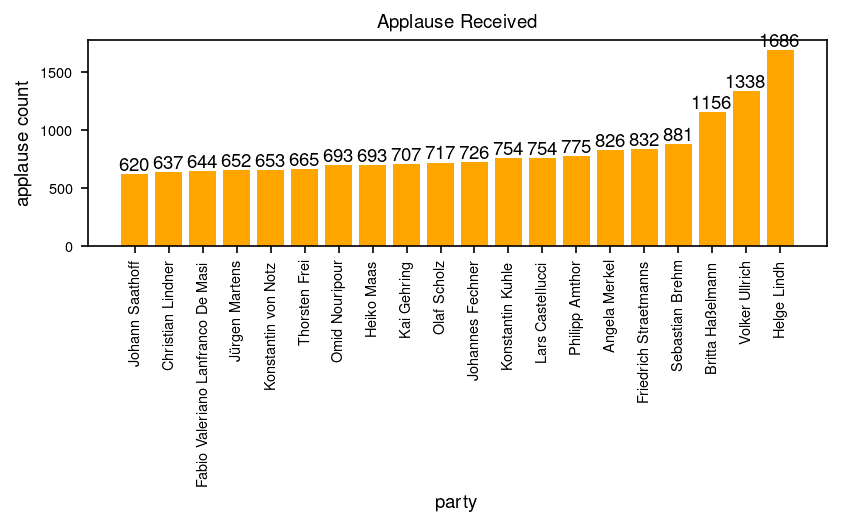

In [73]:
# Tuple of speaker name and applause sum
applauseReceivedSum = [(speaker, applauseDF["applause count"].sum())
                       for (speaker, applauseDF) in applauseReceived]

print("Overall Applause: ", sum([s for (_, s) in applauseReceivedSum]))

# Only top n speakers
n = 20
mostApplauded = sorted(applauseReceivedSum, key=lambda s: s[1])[-n:]

#plot
fig, ax = plt.subplots()
x = list(zip(*mostApplauded))# get two lists from list of tuples
cntPlot = plt.bar(x[0],x[1], color="orange")
plt.title("Applause Received")
plt.xlabel("party")
plt.ylabel("applause count")
plt.xticks(rotation = 90)
for i, bar in enumerate(cntPlot):
    ax.annotate(bar.get_height(),
                (bar.get_x()+bar.get_width()/2., bar.get_height()),
                ha='center', va='center', xytext=(0, 4), textcoords='offset points')


Who receives applause by which party?


In [74]:
# Now we just take the top 6 (all over 800)
# (Sorry Philipp)
topSix = mostApplauded[-6:]
topSixNames = list(zip(*topSix))[0][::-1]  # ordered from 1 to 6
print(topSixNames)
# This time we only want normalized plots

topApplauseReceived = [(speaker, applauseDF) for speakerName in topSixNames for (
    speaker, applauseDF) in applauseReceived if speakerName == speaker]


('Helge Lindh', 'Volker Ullrich', 'Britta Haßelmann', 'Sebastian Brehm', 'Friedrich Straetmanns', 'Angela Merkel')


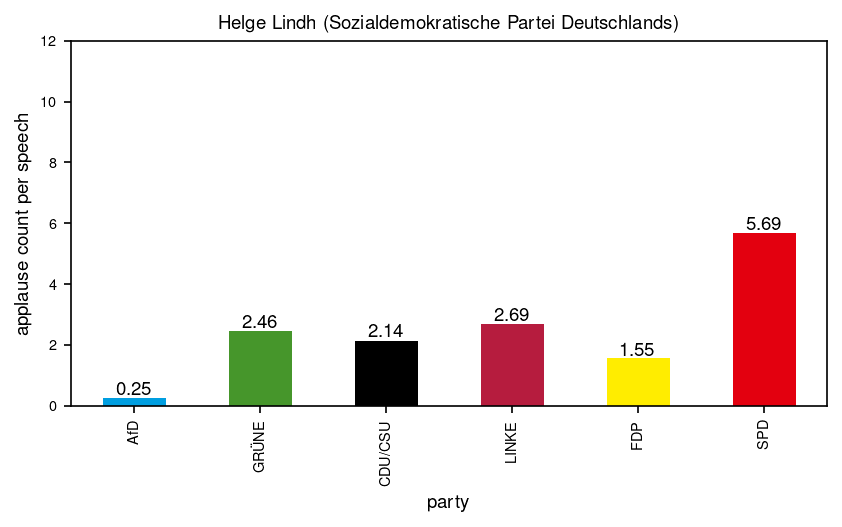

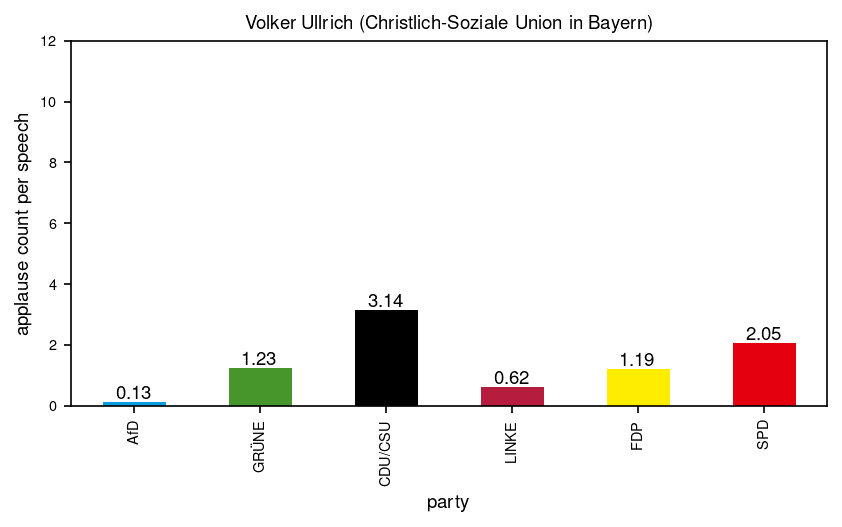

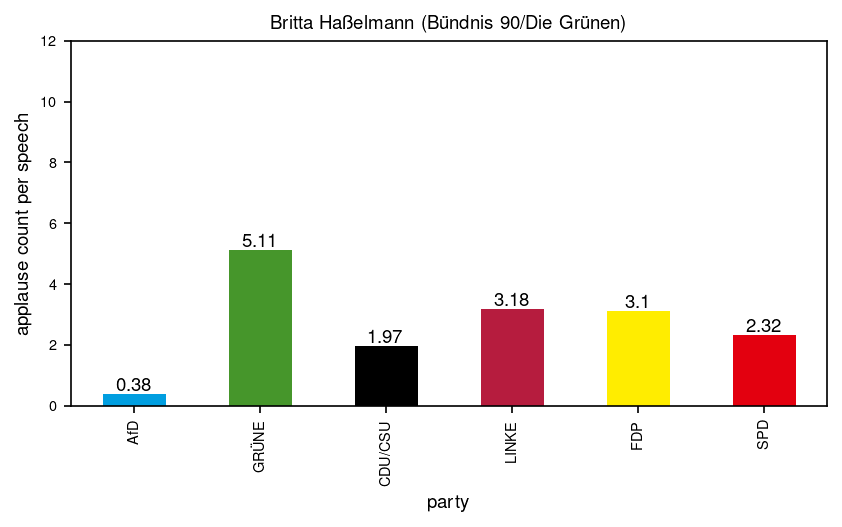

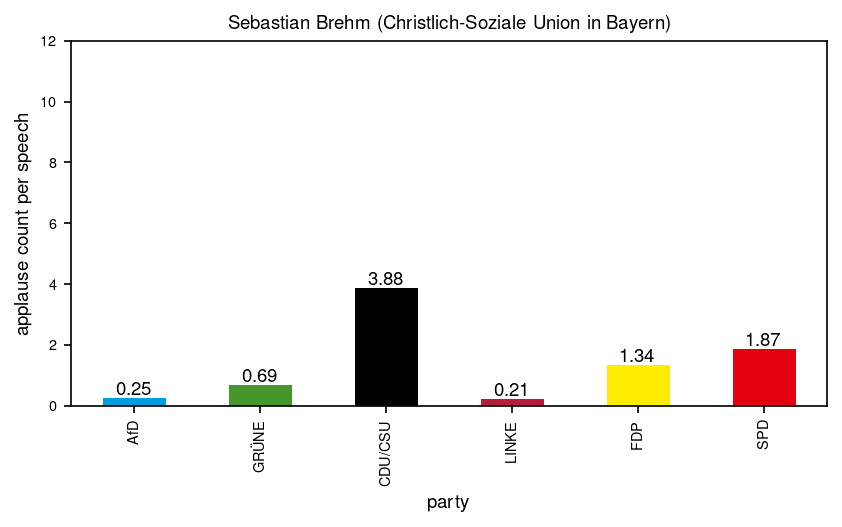

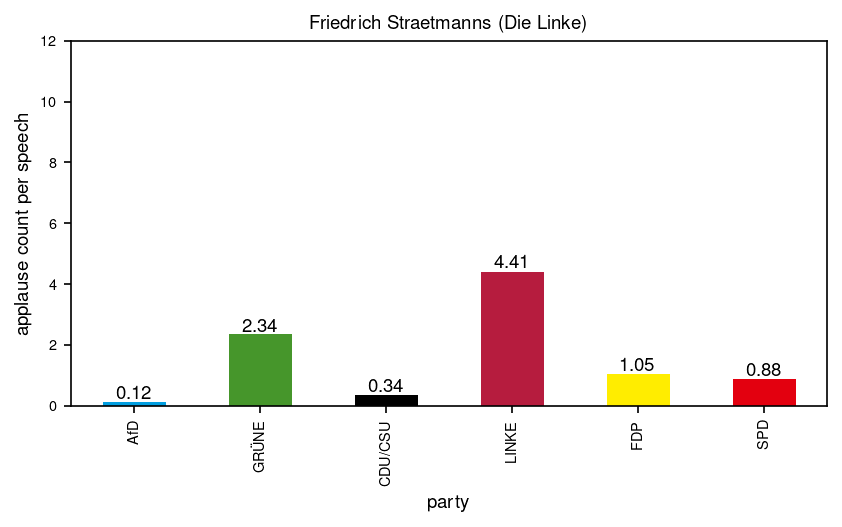

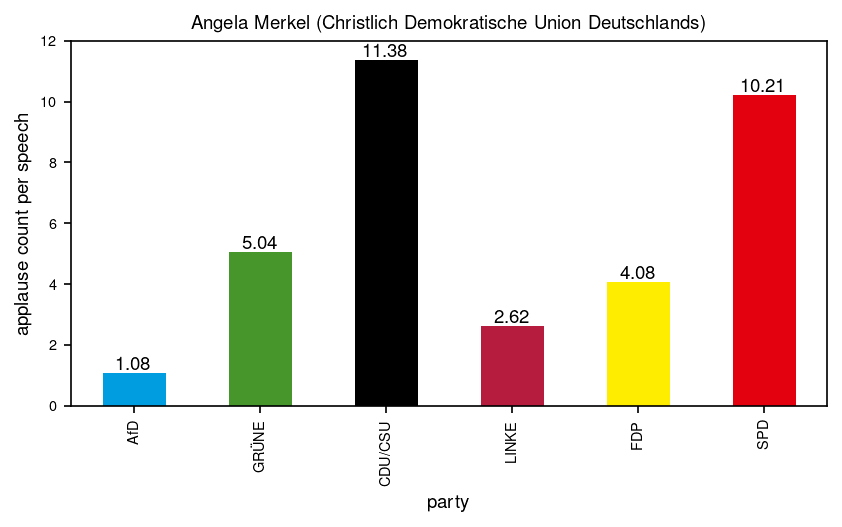

In [75]:
for (speaker, applauseDF) in topApplauseReceived:
    applauseDF["normalized applause count"] = np.round(
        applauseDF["applause count"] / len(dataExtracted[dataExtracted["main-speaker"] == speaker]), 2)
    
    speakerParty = dataExtracted.loc[dataExtracted["main-speaker"] == speaker, "main-speaker-party"].iloc[0]
    
    # plot
    ax = applauseDF.plot.bar(x="party", y="normalized applause count", legend=False,
                             title=f"{speaker} ({speakerParty})", ylim=(0, 12), color=sixParties)  # hard coded y-axis!
    ax.set_ylabel("applause count per speech")
    for p in ax.patches:
        ax.annotate(p.get_height(),
                    (p.get_x()+p.get_width()/2., p.get_height()),
                    ha='center', va='center', xytext=(0, 4), textcoords='offset points')


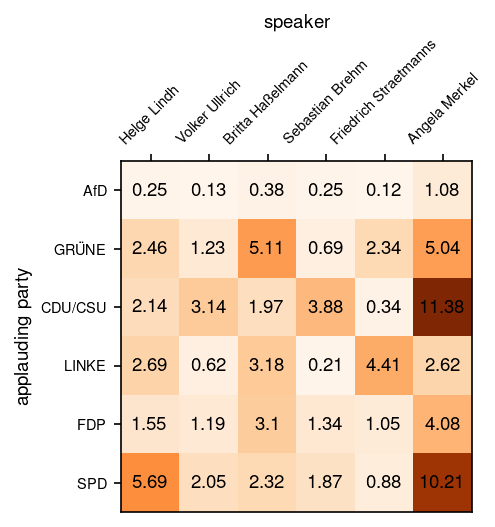

In [76]:
applauseCorrelation = pd.Series(topSixNames, name="speaker")

for (speaker, applauseDF) in topApplauseReceived:
    applauseCorrelation = pd.concat([applauseCorrelation, pd.Series(
        applauseDF["normalized applause count"], name=speaker)], axis=1)

# plot
shortNames = ["AfD", "GRÜNE", "CDU/CSU", "LINKE", "FDP", "SPD"]

applauseMatrix = applauseCorrelation.drop("speaker", axis=1).to_numpy()
axis_values = np.arange(0, len(shortNames), 1)

fig, ax = plt.subplots()
ax.matshow(applauseMatrix, cmap=plt.cm.Oranges)
ax.set_xlabel("speaker")
ax.set_ylabel("applauding party")
ax.xaxis.tick_top()  # no ticks at the bottom
ax.xaxis.set_label_position('top')
ax.set_xticks(axis_values)
ax.set_xticklabels(topSixNames, rotation=45)
ax.set_yticks(axis_values)
ax.set_yticklabels(shortNames)
for i in range(6):
    for j in range(6):
        c = applauseMatrix[j, i]
        ax.text(i, j, str(c), va='center', ha='center')
